<a href="https://colab.research.google.com/github/dragosconst/Anomaly-Detection/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/kaggle_ag_dataset.zip" -d "/content/data/"

Archive:  /content/drive/MyDrive/kaggle_ag_dataset.zip
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


# Imports and global constants

In [ ]:
!pip install transformers

In [34]:
#----------- func typing -----------#
from typing import List, Tuple, Dict, Union, Iterable
#----------- base libs -------------#
import time
import csv
import random
import os
import math
#----------- progress bar ----------#
from tqdm import tqdm
#----------- pickle ----------------#
import pickle
#----------- scikit ----------------#
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
#----------- pytorch ---------------#
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
#----------- numpy -----------------#
import numpy as np
#----------- huggingface -----------#
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel, AdamW, TrainingArguments, Trainer, pipeline
#----------- plot libs -------------#
import seaborn as sn
import matplotlib.pyplot as plt

sn.set_style("darkgrid")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
train_path = '/content/data/train.csv'
test_path = '/content/data/test.csv'

Let's peek at the data:


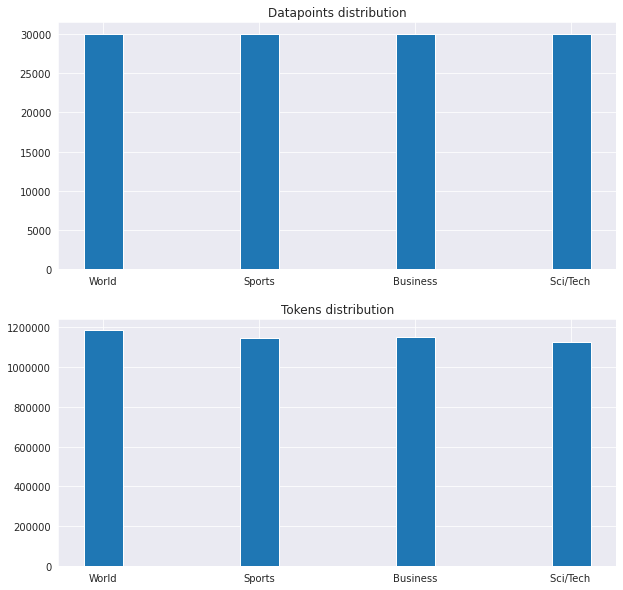

In [27]:
class_bins = np.zeros(4)
class_tokens = np.zeros(4)
with open(train_path, "r") as f:
  reader = csv.reader(f)
  for idx, row in enumerate(reader):
    if idx == 0:
      continue
    cls, title, desc = row
    class_bins[int(cls) - 1] += 1
    title_words = len(title.split(" "))
    desc_words = len(desc.split(" ")) 
    class_tokens[int(cls) - 1] += title_words + desc_words
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[0].bar(["World", "Sports", "Business", "Sci/Tech "], class_bins, width = 0.25)
ax[0].set_title("Datapoints distribution")
ax[1].bar(["World", "Sports", "Business", "Sci/Tech "], class_tokens, width = 0.25)
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_title("Tokens distribution")
plt.show()

Huh, the dataset looks very balanced. In this case, we will arbitrarily choose one class to serve as our normal class for training, and the rest will be considered outlier classes.

In [58]:
normal_class = 2 # we will detect Anomalies on Sports
outlier_classes = [1, 3, 4]

# I will concatenate titles and descriptions, maybe we could try differentiating them
# at training time to compare results
normal_class_instances = []
with open(train_path, "r") as f:
  reader = csv.reader(f)
  for idx, row in enumerate(reader):
    if idx == 0:
      continue
    cls, title, desc = row
    if int(cls) == normal_class:
      normal_class_instances.append(title)
      normal_class_instances.append(desc)

In [43]:
MASK_TOK_ID = 103 # apparently, [MASK] has token id 103 in regular BERT

# Datasets and Dataloaders

In [65]:
class NormalSet(Dataset):
  def __init__(self, class_instances: List, masked_per: float=0.15):
    self.class_instances = class_instances
    self.masked_per = masked_per
    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
  def __len__(self):
    return len(self.class_instances)
  def __getitem__(self, idx):
    if not isinstance(idx, Iterable):
      idx = [idx]
    data = []
    targets = []
    for i in idx:
      data_raw = self.class_instances[i]
      tokenized_bert = self.tokenizer(data_raw, add_special_tokens=True, max_length=100, padding='max_length',
                                return_tensors='pt', truncation=True)
      # ignore padding 
      at_mask = tokenized_bert["attention_mask"]
      relevant_tokens_num = len(at_mask[at_mask == 1]) - 2 # [CLS] and [SEP] shouldn't be masked, probably
      # get mask
      masked_tokens_num = math.floor(relevant_tokens_num * self.masked_per)
      masks = np.random.randint(low=1, high=relevant_tokens_num + 1, size=masked_tokens_num) # [CLS] and [SEP] should only be the first and last tokens
      data_tokens = []
      targets_tokens = []
      # mask the inputs and build the new data and targets
      for idx, tok_id in enumerate(tokenized_bert["input_ids"][0]):
        tok_id = tok_id.item() # tok_ids end up as being one-element tensors because pytorch always returns a tensor when indexing a tensor, for some reason
        gt_tok = tok_id
        if idx in masks:
          tok_id = MASK_TOK_ID
        data_tokens.append(tok_id)
        targets_tokens.append(gt_tok)
      data_tokens = torch.as_tensor(data_tokens)
      targets_tokens = torch.as_tensor(targets_tokens)

      data.append(data_tokens)
      targets.append(targets_tokens)
      return torch.stack(data), torch.stack(targets)

In [66]:
dataset = NormalSet(normal_class_instances)
ds_train, ds_valid = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

BATCH_SIZE=32
dl_train = DataLoader(
    ds_train, batch_size=BATCH_SIZE, shuffle=True
)
dl_valid = DataLoader(
  ds_valid, batch_size=BATCH_SIZE, shuffle=False
)